# Guerrilla traffic speed monitoring to inform and push for change

#### *(or: using open source software and readily available tools to see how fast cars move on Forbes Ave)*

October was a tragic month for the Oakland community in Pittsburgh.  Two pedestrians and a cyclist were killed in car crashes within four days of each other. While the collisions are still under investigation, I have a strong suspicion that speed was a major factor in both.  The survivability of a crash decreases very dramatically as speed increases from 20 to 40 miles per hour [[1]](http://humantransport.org/sidewalks/SpeedKills.htm).

There's been a number of calls for traffic calming measures along Forbes Avenue, which is one of the few routes east for both cars and cyclists.  I was curious what the current average traffic speed is, and if we could strengthen these calls with some real data.  Even though there's no public data and I don't have a RADAR gun, it's possible to collect this myself with just a high vantage point, a cell phone video, and basic computer vision techniques.

The stretch of Forbes Avenue that I'd like to focus on is between Pitt and CMU:
[![Overview map of Forbes Ave, courtesy of Google Maps](assets/overviewmap.png)](https://www.google.com/maps/dir/40.4432009,-79.9535004/40.4446433,-79.9430188/@40.4421918,-79.9560178,16z/data=!4m2!4m1!3e1)

It's here that the road and surrounding area "opens up." The previous 8-10 blocks go through the tightly packed Oakland business district, with timed traffic lights (matching the 25MPH speed limit) at every intersection.  Once you reach Schenley Plaza, though, the buildings recede away and there's a sense of freedom.  I also believe that the timings of lights change at this point, too, allowing you to exceed 25MPH for the first time since the highway exit.  Once you get to the Natural History museum, a fourth travel lane is added on the left and the right lane turns into an unmarked, 20ft wide luxury lane.  The right side of this lane is intended as a bus stop, but the lack of markings makes it a bit of a free-for-all when there aren't any busses.  I believe that all these things contribute to an overall increase in speed.

I don't have a RADAR gun, but I do have a cell phone and access to the Cathedral of Learning.  At 3:30pm on Friday afternoon, I recorded 10 minutes of traffic on Forbes Ave.  Here's a snippet of what this looked like:
![Two second snippet of the raw footage](assets/movieclip.gif)

You can see Dippy the Dino on the top left, with Schenley Plaza on the top right, and the intersection with Schenley Drive Extension in between.  Unfortunately the trees obscure the section of the road where I think traffic moves the fastest, but there's a great view of about 300ft of the road.  I rotated and cropped the image, used basic image processing techniques to detect objects and their locations, converted pixels to meters, and computed their speeds. The full analysis is documented below. It worked surprisingly well:
![The same two second snippet, but rotated, cropped, and annotated with speeds in MPH](assets/processedclip.gif)


## Analysis

I'll use Julia v0.4 and a bunch of Julia packages to do this analysis, but the concepts are applicable in any language. Unless otherwise noted, all code is copyright 2015 Matt Bauman, available for use with attribution under the [MIT license](http://opensource.org/licenses/MIT). All videos and images are similarly copyright 2015 Matt Bauman, available for use with attribution under the Creative Commons Attribution 4.0 International License ([CC-BY](https://creativecommons.org/licenses/by/4.0/)).

First, there's some setup.  I try to make use of as many existing packages as possible.  I also define a few helper utilities up front.

In [1]:
using Images, FixedPointNumbers, ImageMagick, Colors, Gadfly, DataFrames, ProgressMeter
import VideoIO

    ./(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDataArray}) at /Users/jehiah/.julia/v0.4/DataArrays/src/broadcast.jl:285
is ambiguous with: 
    ./(Images.AbstractImageDirect, AbstractArray) at /Users/jehiah/.julia/v0.4/Images/src/algorithms.jl:55.
To fix, define 
    ./(Images.AbstractImageDirect, Union{DataArrays.DataArray, DataArrays.PooledDataArray})
before the new definition.
    +(AbstractArray, DataArrays.DataArray) at /Users/jehiah/.julia/v0.4/DataArrays/src/operators.jl:326
is ambiguous with: 
    +(Images.AbstractImageDirect, AbstractArray) at /Users/jehiah/.julia/v0.4/Images/src/algorithms.jl:18.
To fix, define 
    +(Images.AbstractImageDirect, DataArrays.DataArray)
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /Users/jehiah/.julia/v0.4/DataArrays/src/operators.jl:349
is ambiguous with: 
    +(Images.AbstractImageDirect, AbstractArray) at /Users/jehiah/.julia/v0.4/Images/src/algorithms.jl:18.
To fix, define 
    +(Images

In [2]:
# Let's create a GIF to display a snippet of the raw footage. There aren't any (to my knowledge) native
# Julia libraries to work with GIFs, but we have ImageMagick installed through BinDeps, which uses Homebrew
# since I'm on a Mac.  So let's just create a simple helper function to shell out to the `convert` binary.

# Inspired by Tom Breloff's animated plots: https://github.com/tbreloff/Plots.jl/blob/master/src/animation.jl
immutable GIF
    data::Vector{UInt8}
end
import Homebrew
"""
    animate(f, n; fps=20, width)

Call function `f` repeatedly, `n` times. The function `f` must take one argument (the frame number),
and it must return an Image for that frame.  Optionally specify the number of frames per second
and a width for proportional scaling (defaults to the actual width).
"""
function animate(f, n; fps = 20, width=0)
    mktempdir() do dir
        for i=1:n
            img = f(i)
            frame = width > 0 ? Images.imresize(img, (width, floor(Int, width/size(img, 1) * size(img, 2)))) : img
            Images.save(@sprintf("%s/%06d.png", dir, i), frame)
        end
        speed = round(Int, 100 / fps)
        run(`$(Homebrew.brew_prefix)/bin/convert -delay $speed -loop 0 $dir/*.png $dir/result.gif`)
        return GIF(open(readbytes, "$dir/result.gif"))
    end
end
Base.writemime(io::IO, ::MIME"text/html", g::GIF) = write(io, "<img src=\"data:image/gif;base64,$(base64encode(g.data))\" />")
Base.write(io::IO, g::GIF) = write(io, g.data)

write (generic function with 71 methods)

In [160]:
# The VideoIO library is really great, but it's missing a random access seeking API.
# This should eventually be pushed upstream (https://github.com/kmsquire/VideoIO.jl/issues/30)
function Base.seek(s::VideoIO.VideoReader, time, video_stream=1)
    pCodecContext = s.pVideoCodecContext
    seek(s.avin, time, video_stream)
    VideoIO.avcodec_flush_buffers(pCodecContext)
    s
end

function Base.seek(avin::VideoIO.AVInput, time, video_stream = 1)
    # AVFormatContext
    fc = avin.apFormatContext[1]

    # Get stream information
    stream_info = avin.video_info[video_stream]
    seek_stream_index = stream_info.stream_index0
    stream = stream_info.stream
    time_base = stream_info.codec_ctx.time_base
    ticks_per_frame = stream_info.codec_ctx.ticks_per_frame

    pos = Int(div(time*time_base.den, time_base.num*ticks_per_frame))
    # println("seek $pos in $video_stream time_base:$time_base ticks_per_frame:$ticks_per_frame seek_stream_index:$seek_stream_index")
    # Seek
    ret = VideoIO.av_seek_frame(fc, seek_stream_index, pos, VideoIO.AVSEEK_FLAG_ANY)

    ret < 0 && throw(ErrorException("Could not seek to start of stream"))

    return avin
end

# While we're at it, It's very handy to know how many frames there are:
Base.length(s::VideoIO.VideoReader) = s.avin.video_info[1].stream.nb_frames

length (generic function with 133 methods)

In [4]:
# So now we can load our video, seek to a spot with some nice action, and create a GIF for display
io = VideoIO.open("IMG_2399.MOV")
f = VideoIO.openvideo(io)

seek(f, 5*60+18)
gif = animate(60, fps=30, width=450) do _
    read(f, Image)
end
open("movieclip.gif", "w") do f
    write(f, gif)
end
gif

# While it's handy to embed gifs into the notebook when working interactively,
# it makes the notebook too big to render online. So instead, just point to the saved file.
display("text/html", """<img src="movieclip.gif" />""")

## Selecting the region of interest

The very first step in image processing is to define the region of interest. This is often done just by cropping and manually selecting the pixels you're interested in looking at.  But in our case we can make life a lot easier if we also rotate the image so the cars just travel along one axis.

Rotating an image is inherently an interpolation-like process. The naive way to rotate an image is to move the locations of each pixel, but the new locations won't end up at integer coordinates. In order to display the image on the screen, you need to interpolate the value of each new pixel from the nearby rotated pixels. This is hard and requires lots of bookkeeping.  The easy way to rotate an image is to tilt your head the opposite direction. Or less facetiously, you can instead rotate the *indices* into the image the opposite direction.  This is the approach that AffineTransforms.jl takes, with support for all sorts of transformations.  Coupled with Interpolations.jl, this allows for fast and robust lazy transformations.

In [5]:
using Interpolations, AffineTransforms

"""
Rotate and crop a matrix by the angle θ.

Optional arguments:
* region - a tuple of two arrays that specify the section of the rotated image to return; defaults to the unrotated viewport
* fill - the value to use for regions that fall outside the rotated image; defaults to zero(T)
"""
function rotate_and_crop{T}(A::AbstractMatrix{T}, θ, region=(1:size(A, 1), 1:size(A, 2)), fill=zero(T))
    etp = extrapolate(interpolate(A, BSpline(Linear()), OnGrid()), fill)
    R = TransformedArray(etp, tformrotate(θ))
    Base.unsafe_getindex(R, region[1], region[2]) # Extrapolations can ignore bounds checks
end

# While the above will work for images, it may iterate through them inefficiently depending on the storage order
rotate_and_crop(A::Image, θ, region) = shareproperties(A, rotate_and_crop(A.data, θ, region))

rotate_and_crop (generic function with 4 methods)

In [213]:
# This is what we actually want: A rotated and cropped image that just shows the unobstructed section of Forbes Ave:
seekstart(f)
img = read(f, Image)
# Images.save("temp-frame-before.png", img)
# display("text/html", """<img src="temp-frame-before.png" />""")
# original (721:1821,24:201)
cropped = rotate_and_crop(img, 0.321, (250:615, 0:65))
Images.save("cropped-frame.png", cropped)
display("text/html", """<img src="cropped-frame.png?a=4" />""")


In [49]:
# This gets called often, so let's optimize it a little bit.  Instead of just 
# using read, I use the internal `retrieve!` with a pre-allocated buffer.
# This is safe since I know it's getting rotated and discarded immediately
const _buffer = Array{UInt8}(3, size(img.data, 1), size(img.data, 2))
function readroi(f::VideoIO.VideoReader, region=(1:size(A, 1), 1:size(A, 2)))
    VideoIO.retrieve!(f, _buffer)
    # _buffer is a 3-dimensional array (color x width x height), but by reinterpreting
    # it as RGB{UFixed8}, it becomes a matrix of colors that we can rotate
    Image(rotate_and_crop(reinterpret(RGB{UFixed8}, _buffer), 0.321, region), Dict("spatialorder"=>["x","y"]))
end

readroi (generic function with 2 methods)

## Object detection

Now that we have our region of interest, we want to identify the vehicles.  The first step is to find a frame without any vehicles — this will define the background.  We just want to discard everything in the background.

In [214]:
# println(f)
# original index: 2*60+40.5
# should be 20s, but 30*650 works
seekstart(f)
seek(f, (30*34*20))
# original (721:1821,24:201)
background = readroi(f, (250:615, 0:65))
Images.save("temp-bg.png", background)
display("text/html", """<img src="temp-bg.png?a=$(rand(1:100))" />""")


Great! We can now go back to the beginning of the movie, and *subtract* the background from it! Pixels that are close in color to the background will be black, whereas new objects in the frame will have a different color value from the background and therefore be brighter (or maybe negative, which is rather non-sensical for a color).

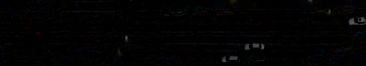

In [227]:
# To subtract the background, first convert both to RGB{Float32} images.  Subtracting RGB{UFixed8}s
# is problematic because they are just unsigned 8-bit integers. So instead of going negative, they
# *wrap around* to the maximum value. Using floating point numbers to represent the colors fixes this:
seekstart(f)
img = readroi(f, (250:615, 0:65))
Images.save("temp.png", img)
display("text/html", """<img src="temp.png?a=$(rand(1:100))" />""")
convert(Image{RGB{Float32}}, img) - convert(Image{RGB{Float32}}, background)

You can somewhat see the four cars here. This is a "color" image, but we don't really care what colors the things are -- we just want the maximum deviation from the background. To do this, we can take the absolute value of each color and sum them all together:

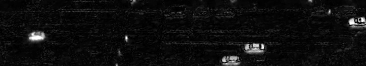

In [217]:
# Absolute value is defined for RGB colors, but it's a little wonky -- it's the *sum* of the absolute values
# of the components. It is exactly what we want, but it's not defined for arrays of RGBs, so we add that definition here:
@vectorize_1arg AbstractRGB Base.abs
grayim(abs(convert(Image{RGB{Float32}}, img) - convert(Image{RGB{Float32}}, background)))

Now they really pop!  You can also clearly see a few pedestrians waiting to cross at the crosswalk.  The key to image processing is often just figuring out how to simplify your images as much as possible.  The next step is to make things even simpler.  Let's define a threshold value and make this image black and white, and square it to make big differences even bigger:

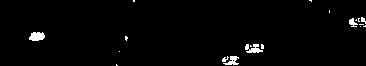

In [218]:
import Base: .^
function (.^)(img::Image{RGB{Float32}}, pow::Integer)
    copy!(similar(img), reinterpret(RGB{Float32}, reinterpret(Float32, img).^pow))
end
grayim(map(UFixed8, grayim(abs((convert(Image{RGB{Float32}}, img) - convert(Image{RGB{Float32}}, background)).^2))  .> .06))

That works, but it's a little noisy.  Let's add a bit of a blur to smooth things out a bit. One other difficulty we run into is that these car areas can bleed into each other from different lanes.  The cars in the far lanes cast a shadow on the ground, extending their detected area into the nearer lanes.  And we have some perspective difficulties, where tall vehicles in the near lanes can end up overlapping with the farther lanes.  When two of these blobs touch they merge into one object, which can cause strange effects in the resulting speeds.  By explicitly ignoring the areas between the lanes, we can prevent this from happening.

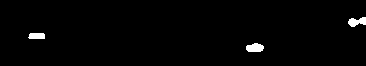

In [225]:
mask = imfilter_gaussian(grayim(abs((convert(Image{RGB{Float32}}, img) - convert(Image{RGB{Float32}}, background)).^2)),[3,3]) .> .06
# mask[:,61:69] = false
# mask[:,97:105] = false
# mask[:,129:137] = false

# 13, 24, 36, 49
mask[:,13:14] = false
mask[:,29:33] = false
mask[:,40:43] = false
mask[:,53:66] = false

grayim(map(UFixed8, mask))

Now we have a black and white image that we can pass to one of the core algorithms in image processing: labeling connected components. Basically, the algorithm goes through and finds each connected white area, filling it with a unique identifier.  I think of it as acting like photo editing software's paint bucket, coloring inside the lines with a new color for each section:

Found 3 connected areas


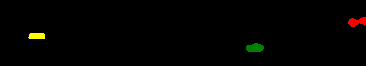

In [228]:
labels = label_components(mask) # This is like MATLAB's bwlabel
println("Found $(maximum(labels)) connected areas")
# Demonstrate how it works by assigning each label to a different color and displaying the colored identifications:
colors = [colorant"black", colorant"red", colorant"yellow", colorant"green", colorant"blue", colorant"orange", colorant"purple", colorant"gray", colorant"brown"]
Image(map(x->colors[x+1], labels'))

In [241]:
# Let's put this all together into a function:
function labelimg(img, background, blur=[3,3], tolerance=0.06)
    mask = imfilter_gaussian(grayim(abs((convert(Image{RGB{Float32}}, img) - convert(Image{RGB{Float32}}, background)).^2)),blur) .> tolerance
    mask::BitMatrix # Converting images isn't type stable, so giving inference a hint here helps speed things up
#     mask[:,61:69] = false
#     mask[:,97:105] = false
#     mask[:,129:137] = false
    mask[:,11:14] = false
    mask[:,27:29] = false
    mask[:,41:43] = false
    mask[:,53:66] = false

    label_components(mask)
end

labelimg (generic function with 3 methods)

## Tracking the cars over time

So now that we can find the vehicles in each frame, we must track them over time across multiple images.  I define a custom aggregate type to help keep track of the centers of mass, extents of each area, and the total number of pixels.  Now we can convert our labelled image into a vector of Positions. By filtering out the areas smaller than a car, we end up with the four vehicles we expect!

In [245]:
using StatsBase
immutable Position
    x::Float64
    y::Float64
    xspan::UnitRange{Int}
    yspan::UnitRange{Int}
    mass::Int
end
function positions(labels)
    N = maximum(labels)
    ps = Vector{Position}(N)
    for i=1:N
        mask = labels .== i
        xs = sum(mask, 2)
        ys = sum(mask, 1)
        ps[i] = Position(mean(1:length(xs), weights(xs)), mean(1:length(ys), weights(ys)),
                         findfirst(xs):findlast(xs), findfirst(ys):findlast(ys),
                         sum(xs))
    end
    ps
end

ps = positions(labels)
filter(p->p.mass > 75, ps)


3-element Array{Position,1}:
 Position(357.6218487394958,22.369747899159663,349:366,18:27,119) 
 Position(37.410526315789475,36.56842105263158,29:45,34:39,95)    
 Position(255.51937984496124,48.457364341085274,247:264,44:52,129)

I put this all together, loop through each frame, and use a simple heuristic to see if the objects detected within that frame match any from the previous frames.  Cars won't be crashing into each other, so we can find cars in the new frame that overlap with those in the previous one.  I store this into a "tall" DataFrame, where each column is an independent variable (position, ID, and time) and each row is just one observation.

In [ ]:
# One position *contains* another if its span contains the other's center
Base.in(a::Position, b::Position) = round(a.x) in b.xspan && round(a.y) in b.yspan

function identifyvehicles(f, background, max_frames = length(f))
    # These three vectors are where the end result goes
    vehicle_pos = Position[]
    vehicle_ids = Int[]
    vehicle_time = Int[]

    # We also keep a list of active positions from the previous frame
    active_pos = Position[]
    active_ids = Int[]

    seekstart(f)
    next_id = 1 # This will be the ID of the next "new" vehicle that enters the frame
    @showprogress for frame=1:max_frames
        eof(f) && break

        img = readroi(f, (250:615, 0:65))
        labels = labelimg(img, background)
        ps = filter(p->p.mass > 75, positions(labels))
        isactive = falses(length(active_pos))
        for p in ps
            id = 0;
            # Look to see if this vehicle is already active
            for i=1:length(active_pos)
                if p in active_pos[i] && active_pos[i] in p
                    id = active_ids[i]
                    active_pos[i] = p
                    isactive[i] = true
                    break
                end
            end
            if id == 0
                # We didn't find a matching active vehicle; use a new id
                id = next_id
                next_id += 1
                # And store it as an active vehicle
                push!(active_pos, p)
                push!(active_ids, id)
                push!(isactive, true)
            end

            push!(vehicle_pos, p)
            push!(vehicle_ids, id)
            push!(vehicle_time, frame)
        end
        active_pos = active_pos[isactive]
        active_ids = active_ids[isactive]
    end
    DataFrame(Any[vehicle_time, vehicle_pos, vehicle_ids], [:frame, :pos, :id])
end
seekstart(f)
df = identifyvehicles(f, background)
display(head(df, 10))


Progress:  13%|█████                                    |  ETA: 0:02:03

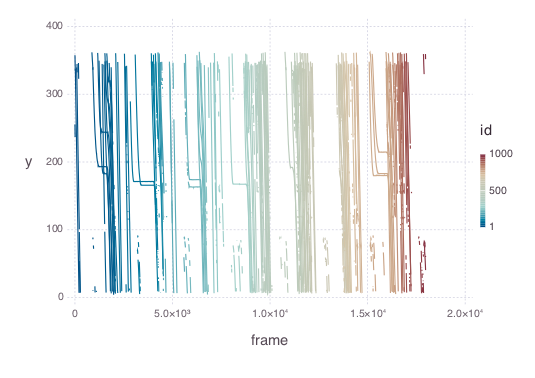

In [233]:
# Let's look at the position of the cars over time:
plot(df, x=:frame, y=map(p->p.x, df[:pos]), color=:id, Geom.line()) 

## Converting pixels to meters

While it's pretty cool that we have identified cars and can track them across the video, we still don't know how fast they're going because we don't know how to convert from pixels to a real unit like meters.  This ended up being much more difficult than I anticipated.  Not only do I need to find a conversion between pixels to meters, but this conversion factor varies across the video due to the perspective!  So I needed to find multiple reference points in order to put a scale bar (or bars) on this video.

**Busses to the rescue.**  Most of the Pittsburgh Port Authority's bus fleet is comprised of [40' Gillig Low Floor (or Advantage)](https://en.wikipedia.org/wiki/Gillig_Low_Floor) and 60' articulating busses.  Unfortunately no 60 footers went past in the ten minute video, but several 40' busses go by.  At first I tried measuring the bus itself, but this proved difficult.  The edges were fuzzy and tough to mark in the video, and I also had a hard time finding the exact measurements here because it seems many agencies customize bumpers or add bike racks.  The wheelbase, however, is much more precise, both in its specification (279 inches) and my ability to mark the centers of the wheels.  So I grabbed snippets from both the right and left lanes and marked the wheels on the image directly.  This allowed me to estimate the pixel density along the x-axis at 10 different points.

In [173]:
# let's find some busses
function peek_img(i, t)
    seekstart(f)
    seek(f, t)
    Images.save("peek-bus-$i.png", readroi(f, (250:615, 0:65)))
    display("text/html", """<img src="peek-bus-$i.png?a=$(rand(1:100))" />""")
end

peek_img(1, 34*30*(5*60+55))
peek_img(2, 34*30*(6*60+4))
peek_img(3, 34*30*(6*60+10))
peek_img(4, 34*30*(6*60+13))

peek_img(5, 34*30*(2*60+39))
peek_img(6, 34*30*(2*60+40))
peek_img(7, 34*30*(2*60+42))
peek_img(8, 34*30*(2*60+44))



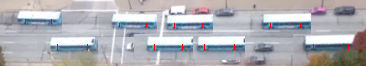

In [180]:
density = Vector{Float64}(0) # The pixel density
density_x = Vector{Float64}(0) # The locations of a specific density measurement
density_y = Vector{Float64}(0)
wheelbase = 7.087 # 279 inches in meters

img = copy(background)
function draw_and_store_density!(img, f, t, burnframes, x1, x2, y)
    # Go to the specified frame
    seek(f, 30*34*t)
    # Sometimes seeking isn't precise enough, and we need to burn a few frames:
    for i=1:burnframes; readroi(f, (250:615, 0:65)); end
    # Grab the image
    frame = readroi(f, (250:615, 0:65))
    # Store the bus into the passed image
    img[x1-20:x2+10, minimum(y)-10:maximum(y)+10] = frame[x1-20:x2+10, minimum(y)-10:maximum(y)+10]
    img[x1, y] = colorant"red"
    img[x2, y] = colorant"red"
    # And store 
    push!(density, wheelbase/(x2-x1))
    push!(density_x, mean([x1,x2]))
    push!(density_y, mean(y))
end

# Bus in the right lane at 6:00 - 6:30:
# draw_and_store_density!(img, f, 6*60+1, 0, 953, 1046, 54:64)
# draw_and_store_density!(img, f, 6*60+4, 0, 722, 808, 54:64)
# draw_and_store_density!(img, f, 6*60+16, 0, 465, 546, 54:64)
# draw_and_store_density!(img, f, 6*60+20, 0, 205, 280, 47:57)
# draw_and_store_density!(img, f, 6*60+22, 0, 60, 132, 42:52)

draw_and_store_density!(img, f, 5*60+55, 0, 271, 301, 24:28)
draw_and_store_density!(img, f, 6*60+4, 0, 175, 203, 24:28)
draw_and_store_density!(img, f, 6*60+10, 0, 120, 147, 24:27)
draw_and_store_density!(img, f, 6*60+13, 0, 26, 52, 20:24)


# Bus in the left lane at 2:40 - 2:50:
# draw_and_store_density!(img, f, 2*60+42, 12, 929, 1023, 120:130)
# draw_and_store_density!(img, f, 2*60+44, 0, 672, 759, 120:130)
# draw_and_store_density!(img, f, 2*60+46, 0, 372, 453, 120:130)
# draw_and_store_density!(img, f, 2*60+47, 0, 227, 306, 120:130)
# draw_and_store_density!(img, f, 2*60+48, 8, 52, 127, 120:130)

draw_and_store_density!(img, f, 2*60+39, 0, 314, 349, 45:50)
draw_and_store_density!(img, f, 2*60+40, 0, 205, 235, 45:50)
draw_and_store_density!(img, f, 2*60+42, 0, 155, 183, 45:50)
draw_and_store_density!(img, f, 2*60+44, 0, 58, 88, 45:50)

img

This gives us 10 point estimates, but it'd be nice to get a mesh across the image that will allow us to compute speeds anywhere.  Assuming the ground is flat (it's not, but it's pretty close) and the cell phone lens doesn't distort things (it does, but not by much), I'd expect the pixel density to be roughly linear across the image.  So let's use GLM.jl and fit a linear model:

In [181]:
using GLM
# D ~ X+Y is a "Formula" expression. It means that from the dataframe, the D column is a function of X + Y multiplied by some coefficients
m = lm(D ~ X+Y, DataFrame(Any[density, density_x, density_y], [:D, :X, :Y]))

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.DensePredQR{Float64}},Float64}:

Coefficients:
                 Estimate   Std.Error  t value Pr(>|t|)
(Intercept)      0.299214   0.0143561  20.8423    <1e-5
X            -0.000139779  4.51034e-5 -3.09907   0.0269
Y            -0.000828424 0.000369558 -2.24166   0.0751


Let's see what this mesh looks like.  The densities vary from 10cm/pixel to 7.5cm/pixel, which is a surprisingly large amount!  It's a bit tough to tell how well the colored dots match the contour lines, but by looking at the residuals you can see that the linear model fits the data to within 1mm/pixel.

In [183]:
# Column 1 is the intercept, 2 & 3 are the X and Y coefficients
b, mx, my = coef(m)
img = readroi(f, (250:615, 0:65))
# Now let's use the model to construct density estimates for the entire grid
density_grid = [b+mx*x+my*y for x in 1:size(img, 1), y in 1:size(img, 2)]
is, js, vals = findnz(density_grid)
display(plot(layer(x=density_x, y=density_y, color=density, Geom.point()), 
    layer(x=1:size(img, 1), y=1:size(img, 2), z=density_grid, Geom.contour()),
    Coord.cartesian(yflip=true, xmax=366, ymax=66)))

println("Residuals: $(round(residuals(m), 6))")

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -500 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 -380 
 -360 
 -340 
 -320 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 -500 
 0 
 500 
 1000 
 -400 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 
 
 
 
 0.22 
 0.28 
 
 0.26 
 0.24 
 0.20 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Color 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M123.88,69.99 L 123.59 70.17 123.3 70.36 123.01 70.54 122.72 70.73 122.43 70.92 122.32 70.99 122.14 71.1 121.85 71.29 121.56 71.48 121.27 71.66 120.98 71.85 120.7 72.03 120.6 72.1 120.41 72.22 120.12 72.41 119.83 72.59 119.54 72.78 119.25 72.96 118.96 73.15 118.88 73.2 118.67 73.34 118.38 73.52 118.09 73.71 117.8 73.9 117.51 74.08 117.22 74.27 117.17 74.3 116.93 74.45 116.64 74.64 116.35 74.83 116.06 75.01 115.77 75.2 115.48 75.38 115.45 75.41 115.19 75.57 114.9 75.76 114.61 75.94 114.32 76.13 114.03 76.32 113.74 76.5 113.73 76.51 113.45 76.69 113.16 76.87 112.87 77.06 112.58 77.25 112.29 77.43 112.02 77.61 112 77.62 111.72 77.8 111.43 77.99 111.14 78.18 110.85 78.36 110.56 78.55 110.3 78.72" class="geometry color_" stroke="#ABCEC4"/>
 <path fill="none" d="M123.88,61.26 L 123.59 61.44 123.3 61.63 123.01 61.82 122.72 62 122.47 62.17 122.43 62.19 122.14 62.37 121.85 62.56 121.56 62.75 121.27 62.93 120.98 63.12 120.75 63.27 120.7 63.3 120.41 63.49 120.12 63.68 119.83 63.86 119.54 64.05 119.25 64.24 119.03 64.37 118.96 64.42 118.67 64.61 118.38 64.79 118.09 64.98 117.8 65.17 117.51 65.35 117.32 65.48 117.22 65.54 116.93 65.72 116.64 65.91 116.35 66.1 116.06 66.28 115.77 66.47 115.6 66.58 115.48 66.66 115.19 66.84 114.9 67.03 114.61 67.21 114.32 67.4 114.03 67.59 113.88 67.68 113.74 67.77 113.45 67.96 113.16 68.14 112.87 68.33 112.58 68.52 112.29 68.7 112.17 68.79 112 68.89 111.72 69.08 111.43 69.26 111.14 69.45 110.85 69.63 110.56 69.82 110.45 69.89 110.27 70.01 109.98 70.19 109.69 70.38 109.4 70.57 109.11 70.75 108.82 70.94 108.73 70.99 108.53 71.12 108.24 71.31 107.95 71.5 107.66 71.68 107.37 71.87 107.08 72.05 107.02 72.1 106.79 72.24 106.5 72.43 106.21 72.61 105.92 72.8 105.63 72.99 105.34 73.17 105.3 73.2 105.05 73.36 104.76 73.54 104.47 73.73 104.18 73.92 103.89 74.1 103.6 74.29 103.58 74.3 103.31 74.47 103.03 74.66 102.74 74.85 102.45 75.03 102.16 75.22 101.87 75.41 101.87 75.41 101.58 75.59 101.29 75.78 101 75.96 100.71 76.15 100.42 76.34 100.15 76.51 100.13 76.52 99.84 76.71 99.55 76.89 99.26 77.08 98.97 77.27 98.68 77.45 98.43 77.61 98.39 77.64 98.1 77.83 97.81 78.01 97.52 78.2 97.23 78.38 96.94 78.57 96.72 78.72" class="geometry color_" stroke="#B5CCC1"/>
 <path fill="none" d="M123.88,52.53 L 123.59 52.71 123.3 52.9 123.01 53.09 122.72 53.27 122.62 53.34 122.43 53.46 122.14 53.65 121.85 53.83 121.56 54.02 121.27 54.2 120.98 54.39 120.9 54.44 120.7 54.58 120.41 54.76 120.12 54.95 119.83 55.13 119.54 55.32 119.25 55.51 119.19 55.55 118.96 55.69 118.67 55.88 118.38 56.07 118.09 56.25 117.8 56.44 117.51 56.62 117.47 56.65 117.22 56.81 116.93 57 116.64 57.18

Residuals: [-0.001464,0.001851,0.003053,-0.00296,-0.011041,0.007121,0.016866,-0.013426]


Next, I convert the mesh of pixel densities to actual distances.  Note that these aren't the actual positions — this doesn't account for the very different pixel density along the y dimension nor the skew across the image.  But we're only measuring the velocity along the x-axis, and since we restrict detections to within single lanes, we know that the vehicles aren't moving significantly along our un-calibrated axis.

It'd be really nice to validate this measurement against some other distances in the image.  There are some faded marks on the pavement that are separate from the intersection markings.  My hunch is that they might be old [VASCAR](https://en.wikipedia.org/wiki/VASCAR) lines, and may be exactly 100ft or some other even multiple apart.

I can also compare this against satellite imagery, but it's a little tougher to come up with good landmarks that line up well with scale bars.  Using imagery from Apple's Maps, I managed to get a measurement on the solid white lines leading up to the intersection: 75feet.
![Apple Maps with scale](assets/mapscale.png)

Both of these measurements match our coordinate grid nicely.

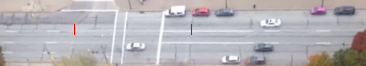

Approximately 29.42 meters, or 96.5 feet


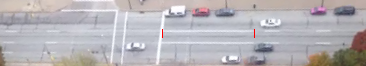

Approximately 21.94 meters, or 71.98 feet


In [192]:
coord_xs = cumsum(density_grid, 1)

# Mark and compute the distance between the faded lines, using the bottom of the mark:
img = copy(background)
img[(x1=75), 25:35] = colorant"red"
img[(x2=192), 25:35] = colorant"red"
display(img)
dist = coord_xs[x2, 35]-coord_xs[x1, 35]
println("Approximately $(round(dist, 2)) meters, or $(round(dist*3.281, 1)) feet")

# And similarly for the solid white line:
img = copy(background)
img[(x1=163), 30:38] = colorant"red"
img[(x2=255), 30:38] = colorant"red"
display(img)
dist = coord_xs[x2, 38]-coord_xs[x1, 38]
println("Approximately $(round(dist, 2)) meters, or $(round(dist*3.281, 2)) feet")

## Computing actual speed!

Finally, we can go back to the dataframe, and compute the actual position in meters and time.  Instead of using the center of mass, I found the mean extents of the car to be a bit less noisy.

,frame,pos,id,x,t
1,1,"Position(357.6218487394958,22.369747899159663,349:366,18:27,119)",1,91.49094986767025,0.033366700033366704
2,1,"Position(255.51937984496124,48.457364341085274,247:264,44:52,129)",2,61.703965941666056,0.033366700033366704
3,2,"Position(356.60655737704917,22.459016393442624,348:366,19:27,122)",1,91.07909995632656,0.06673340006673341
4,2,"Position(253.29268292682926,48.552845528455286,245:261,44:52,123)",2,61.14494111308969,0.06673340006673341
5,3,"Position(356.014598540146,22.642335766423358,346:366,19:27,137)",1,90.8475132722098,0.1001001001001001
6,3,"Position(251.175,48.541666666666664,243:259,44:52,120)",2,60.69663097676373,0.1001001001001001


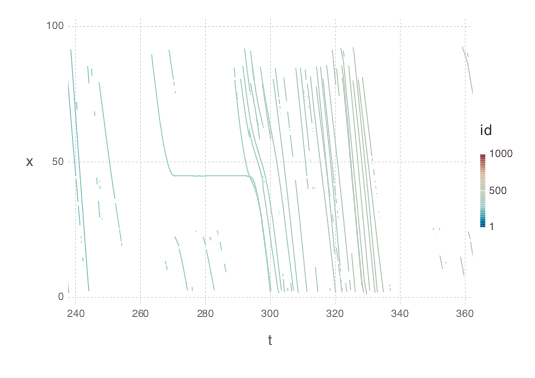

In [234]:
# PHEW! Now we can go back to the dataframe, computing the actual position in meters and time:
x_min = [coord_xs[minimum(p.xspan), round(Int, mean(p.yspan))] for p in df[:pos]]
x_max = [coord_xs[maximum(p.xspan), round(Int, mean(p.yspan))] for p in df[:pos]]
df[:x] = (x_max+x_min)/2
df[:t] = df[:frame]./29.97 # An accessor for the frame rate from VideoIO would be nice, but just hard code it for now
display(head(df))
display("image/png", plot(df, x=:t, y=:x, color=:id, Geom.line(), Coord.Cartesian(xmin=4*60, xmax=6*60))) # Display as a PNG to keep filesize down

Computing the speed requires taking the differential of the position vectors.  These can be notoriously noisy.  A great algorithm for both differentiating and smoothing at the same time is the [Savitzgy-Golay filter](https://en.wikipedia.org/wiki/Savitzky–Golay_filter). In short, it fits a line to a subsection of the data, and then uses the slope of that line as the value of the differential in the middle of that section.  Repeat this across the entire dataset, and you have a smoothed differential!

In [235]:
# Copyright Colm Ryan, licensed under ASL, from the un-registered QLab.jl:
# https://github.com/BBN-Q/Qlab.jl/blob/27550abfe68e001cba20714ecb5efcab0c5689bb/src/SavitskyGolay.jl
# Slightly modified for 0.4 compatibility.
# For a more efficient implementation (and a demonstration of Julia's staged programming), see:
# https://medium.com/@acidflask/smoothing-data-with-julia-s-generated-functions-c80e240e05f3
function savitsky_golay(x::AbstractVector, windowSize::Integer, polyOrder::Integer, deriv::Integer=0)
    #Some error checking
    @assert isodd(windowSize) "Window size must be an odd integer."
    @assert polyOrder < windowSize "Polynomial order must me less than window size."

    halfWindow = div(windowSize-1, 2)

    #Setup the S matrix of basis vectors. 
    S = zeros(windowSize, polyOrder+1)
    for ct = 0:polyOrder
        S[:,ct+1] = collect(-halfWindow:halfWindow).^(ct)
    end

    #Compute the filter coefficients for all orders
    #From the scipy code it seems pinv(S) and taking rows should be enough
    G = S*pinv(S'*S)

    #Slice out the derivative order we want
    filterCoeffs = G[:,deriv+1] * factorial(deriv);

    #Pad the signal with the endpoints and convolve with filter
    paddedX = [x[1]*ones(halfWindow); x; x[end]*ones(halfWindow)]
    y = conv(filterCoeffs[end:-1:1], paddedX)

    #Return the valid midsection
    return y[2*halfWindow+1:end-2*halfWindow]
end

dx = Vector{Float64}(size(df, 1))
groups = unique(df[:id])
for g in groups
    mask = df[:id] .== g
    x = convert(Array{Float64}, df[:x])[mask]
    dx[mask] = savitsky_golay(x, 13, 1, 1)
end
df[:dx] = dx*29.97
display(head(df))

writetable("speeds.csv", DataFrame(Any[df[:frame], df[:id], df[:x], df[:t], df[:dx]], [:frame, :id, :x, :t, :dx]))

# plot(df, x=:t, y=:dx, color=:id, Geom.line()) # Plot omitted to reduce filesize

,frame,pos,id,x,t,dx
1,1,"Position(357.6218487394958,22.369747899159663,349:366,18:27,119)",1,91.49094986767025,0.033366700033366704,-4.298412026821199
2,1,"Position(255.51937984496124,48.457364341085274,247:264,44:52,129)",2,61.703965941666056,0.033366700033366704,-7.35260753299883
3,2,"Position(356.60655737704917,22.459016393442624,348:366,19:27,122)",1,91.07909995632656,0.06673340006673341,-5.534793301235916
4,2,"Position(253.29268292682926,48.552845528455286,245:261,44:52,123)",2,61.14494111308969,0.06673340006673341,-8.964463437211883
5,3,"Position(356.014598540146,22.642335766423358,346:366,19:27,137)",1,90.8475132722098,0.1001001001001001,-6.741133800953552
6,3,"Position(251.175,48.541666666666664,243:259,44:52,120)",2,60.69663097676373,0.1001001001001001,-10.467839979344213


In [238]:
# OK, let's play this video again, this time with speeds annotated!
# The easiest way I know of to print numbers is by punting to Cairo
annotate_frame!(img, frame, df::DataFrame) = annotate_frame!(img, frame, df[:frame], df[:pos], df[:id], df[:dx])
function annotate_frame!(img, frame, frames, pos, ids, dx)
    # Draw a box around each car in this frame, with the speed inscribed
    idxs = find(frames .== frame)
#     println("idxs $idxs")
    for idx in idxs
        p = pos[idx]
        speed = abs(dx[idx])*2.237
        
        # The box
        x1, x2 = extrema(p.xspan)
        y1, y2 = extrema(p.yspan)
        outline = colorant"red"
        if speed <= 30
            outline = colorant"yellow"
        end
        if speed <= 25
            outline = colorant"green" 
        end
        img[x1, p.yspan] = outline
        img[x2, p.yspan] = outline
        img[p.xspan, y1] = outline
        img[p.xspan, y2] = outline
        # The text
        puttext!(img, string(round(Int, speed)), p.xspan, p.yspan)
    end
    img
end
import Cairo
function puttext!(img, str, xspan, yspan)
#     println("$xspan $yspan $str")
    # This is a little convoluted - pass a copy of the image to Cairo, write the text, and assign it back.
    c = Cairo.CairoImageSurface(reinterpret(UInt32, convert(Image{ARGB32}, img)[xspan, yspan]).', Cairo.FORMAT_ARGB32)
    cr = Cairo.CairoContext(c)
    Cairo.save(cr)
    Cairo.move_to(cr, 3., 5.)
    Cairo.set_font_size(cr, 7.)
#     set_line_join(cr, Cairo.CAIRO_LINE_JOIN_ROUND);
    Cairo.show_text(cr, str)
    img[xspan, yspan] = reinterpret(ARGB32, c.data)
    img
end

# crazily, FFMPEG makes it tough (impossible?) to get the current frame number
seekstart(f)
frame_no = floor(Int, (5*60+18)*29.97)
for _=1:frame_no # So we just get there sequentially.
    read(f);
end
gif = animate(60, fps=30, width=366) do i
    annotate_frame!(readroi(f, (250:615, 0:65)), frame_no+i, df)
end
open("processedclip.gif", "w") do f
    write(f, gif)
end
gif

# Again, just point to the clip to keep filesize down
display("text/html", """<img src="processedclip.gif?a=$(rand(1:1000))" />""")

In [239]:
# And now output to a sequence of saved files... which we then convert to a movie with FFMPEG
# VideoIO doesn't support writing videos yet, so we simply output each frame to a folder, and
# shell out to ffmpeg... just like we did with animate (but without the nice wrapper function)
seekstart(f)
gen_pngs(f, df::DataFrame) = gen_pngs(f, df[:frame], df[:pos], df[:id], df[:dx])
function gen_pngs(f, frames, pos, ids, dx)
    seekstart(f)
    isdir("images") || mkdir("images")
    @showprogress for frame=1:maximum(frames)
        img = readroi(f, (250:615, 0:65))
        annotate_frame!(img, frame, frames, pos, ids, dx)
        Images.save("images/$frame.png", img)
    end
end

gen_pngs(f, df)
# run(`$(Homebrew.brew_prefix)/bin/ffmpeg -v 0 -framerate 29.97 -i images/%d.png -y forbesspeed.mp4`)
# this following one should be readable by quicktime
run(`$(Homebrew.brew_prefix)/bin/ffmpeg -framerate 29.97 -i images/%d.png -f mp4 -vcodec h264 -pix_fmt yuv420p -s 366x66 forbesspeed.mp4)

Progress: 100%|█████████████████████████████████████████| Time: 0:06:24


## Cursory analysis of the traffic speed

Now, let's put together some summary statistics about the traffic speed.  In order to do this, we do a group by operation over each identified vehicle.  Let's look at each car's maximum instantaneous speed as well as their speed through the ~100ft pair of faded lines that I think may be old VASCAR markings.  This gives us two metrics: one represents the actual maximums of each tracked car, whereas the other is more representative of how a speed trap in this location might perform.

In [240]:
# Grouped analysis by each detected car. This doesn't need to be very efficient.
by_car = by(df, :id) do car
    dx = car[:dx]
    # The maximum speed of the car, but only if it's tracked for more than 60 frames (~2 seconds)
    # This ignores most of the cars turning from Schenley Drive Ext
    max_speed = length(dx) > 60 ? maximum(abs(dx)) .* 2.237 : NA
    
    # Also compute the "course" time, distance, and speed for approximately the VASCAR lines
    course_start = 591 # in pixels
    course_stop = 245
    ps = car[:pos]
    # Let's use the front of the car, since I think that's how VASCAR timings generally work
    front = map(p->first(p.xspan), ps)
    # Find the index where the front of the car is closest to the course boundaries
    start_offset, start_idx = findmin(abs(front .- course_start))
    stop_offset, stop_idx = findmin(abs(front .- course_stop))
    # Now restrict to cars that have datapoints near both course start and stop:
    if start_offset < 30 && stop_offset < 30
        # Get the average y position over the course for the distance coordinate transform
        mean_y = round(Int, mean(map(p->p.y, ps[start_idx:stop_idx])))
        course_dist = coord_xs[front[start_idx], mean_y] - coord_xs[front[stop_idx], mean_y]
        course_time = (car[:frame][stop_idx] - car[:frame][start_idx])/29.97
        course_speed = (course_dist/course_time)*2.237
        course_start_speed = abs(dx[start_idx])*2.237
        course_stop_speed = abs(dx[stop_idx])*2.237
    else
        course_speed = NA
        course_start_speed = NA
        course_stop_speed = NA
    end
    
    DataFrame(Any[[max_speed], [course_speed], [course_start_speed], [course_stop_speed]], 
                 [:max_speed,  :course_speed,  :course_start_speed,  :course_stop_speed])
end
head(by_car, 6)

,id,max_speed,course_speed,course_start_speed,course_stop_speed
1,1,NA,NA,NA,NA
2,2,NA,NA,NA,NA
3,3,29.853739617439945,NA,NA,NA
4,4,NA,NA,NA,NA
5,5,NA,NA,NA,NA
6,6,29.934615766259192,NA,NA,NA


In [ ]:
p = plot(by_car, x=:max_speed, Geom.histogram(bincount=35))
draw(PNG("max_speeds.png", 6inch, 4inch), p)
display("image/png", p)
println("Cars over 40mph: ", sum((by_car[:max_speed] .> 40) & !isna(by_car[:max_speed])))
println("Cars between 35-40mph: ", sum((35 .< by_car[:max_speed] .<= 40) & !isna(by_car[:max_speed])))
println("Cars between 30-35mph: ", sum((30 .< by_car[:max_speed] .<= 35) & !isna(by_car[:max_speed])))

Let's just look at the fastest speeds.  The 95th percentile is an interesting point, since it represents the speed that one out of every twenty cars is exceeding.  Assuming this random 10-minute sample is representative of afternoon traffic (I have no reason to suspect otherwise), we can bootstrap the distribution to get 95% confidence bounds on this statistic.

In [ ]:
using Bootstrap
max_speeds = by_car[:max_speed][!isna(by_car[:max_speed])]
bs = boot_basic(max_speeds, x->quantile(x, .95), 10000)
ci_bca(bs, .95)

The VASCAR course speed is generally slower since the cars tend to accelerate as they pass through the tracked region.  It represents the average speed over ~100ft.  There are 4 vehicles going over 35 miles per hour in this 10 minute time span.

In [ ]:
display("image/png", plot(by_car, x=:course_speed, Geom.histogram(bincount=35)))
println("Cars over 35mph: ", sum((by_car[:course_speed] .> 35) & !isna(by_car[:course_speed])))

## Exporting data

As one last step, lets export the tracked car positions as a CSV file (and JLD) so others can take a look at the data, too. 

In [ ]:
import JLD
# The jld file contains the pixel Position aggregates, too:
JLD.@save "speeds.jld" df coord_xs

writetable("speeds.csv", DataFrame(Any[df[:frame], df[:id], df[:x], df[:t], df[:dx]], [:frame, :id, :x, :t, :dx]))